## Data Analysis on US Weather Data

In [2]:
import numpy as np
import pandas as pd
import datetime


In [4]:
weatherfile = "E:/Big data/US_WeatherEvents_2016-2019.csv"
weather_df = pd.read_csv(weatherfile)

As can be seen there are 13 columns, which described below.

1. EventId - This is the identifier of a record.
2. Type - The type of an event; examples are rain, fog. snow storm, cold.
3. Severity - The severity of an event, wherever applicable.
4. StartTime(UTC) - The start time of an event in UTC time zone.
5. EndTime(UTC) - The end time of an event in UTC time zone.
6. TimeZone - The US-based timezone based on the location of an event (eastern, central, mountain, and pacific).
7. AirportCode - The airport station that a weather event is reported from.
8. LocationLat - The latitude in GPS coordinate.
9. LocationLng - The longitude in GPS coordinate.
10. City - The city in address record.
11. County - The county in address record.
12. State - The state in address record.
13. ZipCode - The zipcode in address record.

## Question 1
How many snow events were recorded?

Basically we can just use groupby. I created functions to run on the dataset. column_group_percent makes it easier to understand the relative values of the result. The question asked about snow events but it is less work to compute the count for all weather types.

In [5]:
def column_group_count(df, column):
    return df.groupby(column).size()

def column_group_percent(df, column):
    count_groupby = column_group_count(df, column)
    total = count_groupby.sum()
    return (count_groupby/total) * 100


In [6]:
column_group_count(weather_df,'Type').sort_values(ascending = False)

Type
Rain             3067581
Fog              1068653
Snow              679472
Cold              141626
Precipitation      67299
Storm              32688
Hail                2514
dtype: int64

In [7]:
column_group_percent(weather_df, 'Type').sort_values(ascending = False)

Type
Rain             60.626131
Fog              21.120322
Snow             13.428744
Cold              2.799025
Precipitation     1.330064
Storm             0.646029
Hail              0.049685
dtype: float64

So there were 679472 snow events, or 13.4% of the weather events were snow. Interestly fog was the second most common weather event and 60% of the weather events were rain.

## Question 2
How many moderate snow events were recorded each year? Produce a table and line plot

The key observation is to create a function years that accepts a start timestamp and an end timestamp. It returns a list of start year if the start and end are in the same year, otherwise it returns a list containing both the start and end year.

We can then apply this function to the start and end time columns of the weather dataframe. We then use explode to flatten the result into a Series of years. Then just use value_counts to collect the number of events per year.

The needed function:

In [8]:
def year_from_date(date_string):
    """string format 2016-01-17 11:38:00
    returns year string, ie 2016"""
    
    return date_string.split('-')[0]

def years(start_date, end_date):
    """Assumes that start and end are at most 1 year a part
    Returns
        if start and end year are the same return that year in a list
        else return both years in a list"""
    
    start_year = year_from_date(start_date)
    end_year = year_from_date(end_date)
    if (start_year == end_year):
        return [start_year]
    else:
        return [start_year, end_year]

def df_years(a_series):
    """Same as years, but start and end dates are in a series
    Needs for apply function"""
    
    return years(a_series[0], a_series[1])

def select_weather(df, type, severity):
    """df = a_weather_df
    Returns all rows with given type and severity"""
    
    return df.loc[(df['Type'] == type) & (df['Severity'] == severity)]

def count_time(a_weather_df, time_fn):
    date_time_df = a_weather_df[['StartTime(UTC)', 'EndTime(UTC)']]
    series_of_lists_time = date_time_df.apply(time_fn, axis = 1)
    series_of_time = series_of_lists_time.explode()
    return series_of_time.value_counts().sort_index()


Now the answer to the question - Moderate snow events per year

In [9]:
moderate_snow = select_weather(weather_df, 'Snow', 'Moderate')
moderate_snow_counts = count_time(moderate_snow, df_years)
moderate_snow_counts

2016    16900
2017    15780
2018    18686
2019    22290
dtype: int64

In [10]:
moderate_snow_counts.plot()

Did it snow more the last two years? We can look at all snow events.

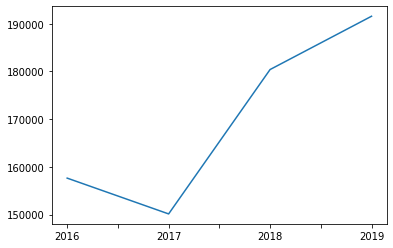

In [11]:
def yearly_weather(a_weather_df, type):
    yearly = a_weather_df.loc[a_weather_df['Type'] == type]
    return count_time(yearly, df_years)

yearly_weather(weather_df, 'Snow').plot()

And what about rain?

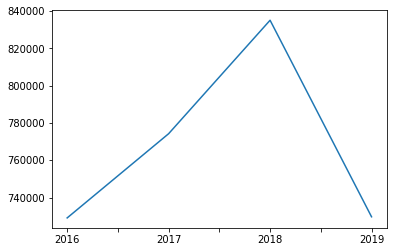

In [12]:
yearly_weather(weather_df,'Rain').plot()

## Question 3
How many snow events were recorded in each state?

The funtion column_group_count already computes this for us. We just need to first select just Snow events.

In [13]:
def snow_per_state(a_weather_df):
    snow_df =  a_weather_df[a_weather_df['Type'] == 'Snow']
    return column_group_count(snow_df,'State')

snow_per_state(weather_df).sort_values(ascending = False)

State
MI    76455
MN    74201
WI    46691
WY    43646
CO    38218
ND    33522
NY    28592
IA    26408
MT    23906
OH    20848
PA    19555
ID    19491
IL    17429
NE    16751
SD    16491
ME    13821
IN    12838
WA    12737
VT    10124
NH     9856
MA     9595
VA     9012
OR     8988
CA     8727
WV     8423
UT     8386
NM     7561
NV     5852
KS     5758
MO     5662
KY     5449
AZ     4973
NC     4820
NJ     3695
TX     3351
CT     3200
OK     3078
MD     2842
RI     1530
AR     1461
TN     1302
GA     1021
SC      837
AL      701
DE      663
MS      535
LA      401
FL       69
dtype: int64

For the most part the results make sense. But some states are smaller than others so even though they get more snow they have fewer reporting stations. The reporting stations appear to be indicated by airport. So we will calculate the number of snow events per reporting station in each state.   

In [14]:
def stations_per_state(a_weather_df):
    """Returns
    Series of number of reporting stations per state as indicated by Airport codes"""
    
    state_airport_df = a_weather_df[['State','AirportCode']]
    return state_airport_df.groupby('State').nunique()['AirportCode']

def snow_per_state_station(a_weather_df):
    """Returns
    Series - average number of snow events per station in each state""" 
    
    snow_state = snow_per_state(a_weather_df)
    stations_state = stations_per_state(a_weather_df)
    return snow_state / stations_state

def combined_snow_events_stations(a_wether_df):
    """Returns
    Dataframe with two columns, one row per state
    Columns:
        Snow Events = snow events per state
        Events/Station = average number of snow events per station in each state
    """
     
    snow_station = snow_per_state_station(weather_df)
    snow_state = snow_per_state(weather_df)
    combined = pd.concat([snow_state, snow_station], axis = 1)
    combined.columns = ['Snow Events', 'Events/Station']
    return combined

def ranked_snow_events_stations(a_weather_df):
    """Returns
    Dataframe with 3 columns, one row per state
    Columns:
        Snow Events = rank of the state in number of snow events, 1 = most
        Events/Station = rank of the state inaverage number of snow events per station, 1 = most
        Change = change in rank of state from Snow Events to Events/Station, 
              positive number indicates state ranked higher Events/Station 
    """
    
    snow_station = snow_per_state_station(a_weather_df).rank(ascending = False)
    snow_state = snow_per_state(a_weather_df).rank(ascending = False)
    rank_delta = snow_state - snow_station
    combined = pd.concat([snow_state, snow_station, rank_delta], axis = 1)
    combined.columns = ['Snow Events', 'Events/Station', "Change"]
    return combined

Now the average number of snow events per station in each state. However it is hard to tell the difference from the number of snow events per state. But ND moved up and MN moved down.

In [149]:
snow_per_station = snow_per_state_station(weather_df)
snow_per_station.sort_values(ascending = False)

State
MI    1033.175676
VT     920.363636
ND     906.000000
MT     853.785714
ME     813.000000
WY     793.563636
MN     764.958763
NH     758.153846
ID     721.888889
WI     718.323077
NY     714.800000
SD     687.125000
CO     616.419355
PA     501.410256
OH     496.380952
WV     495.470588
IA     440.133333
NE     429.512821
MA     417.173913
IN     389.030303
UT     364.608696
CT     320.000000
IL     300.500000
WA     296.209302
OR     272.363636
NV     266.000000
RI     255.000000
DE     221.000000
NJ     217.352941
KY     209.576923
NM     198.973684
MO     171.575758
VA     170.037736
KS     159.944444
AZ     134.405405
MD     118.416667
NC      66.027397
TN      65.100000
CA      64.644444
OK      58.075472
AR      41.742857
SC      19.022727
AL      18.945946
MS      18.448276
TX      18.412088
GA      15.238806
LA       8.911111
FL       0.802326
dtype: float64

We can try displaying both at the same time. But this is not very useful.

In [15]:
both = combined_snow_events_stations(weather_df)
both

,Snow Events,Events/Station
State,,
AL,701,18.945946
AR,1461,41.742857
AZ,4973,134.405405
CA,8727,64.644444
CO,38218,616.419355
CT,3200,320.000000
DE,663,221.000000
FL,69,0.802326
GA,1021,15.238806


Computing the ranks of the states in number of snow events and snow events per station makes it easier to see the changes. Small states like RI, VT, NH and sparsely populated states like ND, MT rank higher is snow events per station. WY a sparsely populated state actually moved down.

In [154]:
ranked = ranked_snow_events_stations(weather_df)
ranked

,Snow Events,Events/Station,Change
State,,,
AL,44.0,43.0,1.0
AR,40.0,41.0,-1.0
AZ,32.0,35.0,-3.0
CA,24.0,39.0,-15.0
CO,5.0,13.0,-8.0
CT,36.0,22.0,14.0
DE,45.0,28.0,17.0
FL,48.0,48.0,0.0
GA,42.0,46.0,-4.0


## Question 4
How many snow events were recorded each hour?

We can use the function count_time from question 2. We just need function that returns the hours of the day (0- 23) given a start and ending timestamp. The hours function below does that. The basic process is to add an hour to the start time until we reach the end time. Use a list comprehension to collect the resulting hours. To make sure we include the start and end hours we use a lower bound for the start time and an upper bound for the end time.

In [16]:
import datetime as dt

def timedelta_to_hours(atimedelta):
    """returns the number of hours in a timedelta object"""
    
    import math
    return math.ceil(atimedelta.days * 24 + atimedelta.seconds / 3600)

def hour_ceil(atimestamp):
    """The goal is to generate the hours (0-23) from a start time to end time.
       To generate the hours we add hours to start 
       until we reach the hour of end. We need make sure to get the hour of end.
       This requires our stop check to be larger that the end. This function
       generates the correct end check time.
       If start = '2019-12-04 20:59:59' and end = '2019-12-04 21:00:00' when
       we add 1 hour to start we get a time greater than the end, so will not
       pick up hour 21. In this case we add 59 minutes and 59 seconds to the end.
       Otherwise we can drop the minutes and seconds and add 1 to the hours.
       """
    
    if (atimestamp.minute == 0):
        return atimestamp + dt.timedelta(minutes = 59) + dt.timedelta(seconds = 59)
    return dt.datetime(atimestamp.year,
                        atimestamp.month,
                        atimestamp.day,
                        hour = atimestamp.hour) + dt.timedelta(minutes = 60)

def hour_floor(atimestamp):
    return dt.datetime(atimestamp.year,
                        atimestamp.month,
                        atimestamp.day,
                        hour = atimestamp.hour)

def add_hours(atimestamp, hours):
    """Add given int hours to a timestamp"""
    
    return atimestamp + dt.timedelta(hours = hours)

def string_to_timestamp(string):
    """Convert a string ('2019-12-07 2:00:00') to timestamp"""
    
    return dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

def hours(start,end):
    """start and end are strings representing a timestamp ('2019-12-07 2:00:00')
       start has to be before end
    Returns list of hours of the day from start time to end time, including
       start and end
       """
    start_timestamp = hour_floor(string_to_timestamp(start))
    end_timestamp = hour_ceil(string_to_timestamp(end))
    hourrange = range(timedelta_to_hours(end_timestamp - start_timestamp))
    return [add_hours(start_timestamp, x).hour for x in hourrange
            if add_hours(start_timestamp,x) <= end_timestamp]

def df_hours(series):
    """Same as hours, but start and end dates are in a series
    Needs for apply function"""
    return hours(series[0], series[1])

Some tests

In [17]:
assert(22 == hour_ceil(string_to_timestamp('2019-12-04 21:52:00')).hour)
assert(22 == hour_ceil(string_to_timestamp('2019-12-04 21:00:01')).hour)
assert(21 == hour_ceil(string_to_timestamp('2019-12-04 21:00:00')).hour)

assert([21] == hours('2019-12-04 21:00:00','2019-12-04 21:59:00'))
assert([21, 22] == hours('2019-12-04 21:01:00','2019-12-04 22:02:00'))
assert([21] == hours('2019-12-04 21:59:00','2019-12-04 21:59:59'))
assert([21, 22] == hours('2019-12-04 21:59:00','2019-12-04 22:00:00'))
assert([23, 0] == hours('2019-12-04 23:59:00','2019-12-05 0:00:00'))
assert([23, 0] == hours('2019-12-31 23:59:00','2020-01-01 0:00:00'))
assert(list(range(1,23)) == hours('2019-12-04 1:01:00','2019-12-04 22:00:00'))
assert([x % 24 for x in range(1,75)] == hours('2019-12-04 1:00:00','2019-12-07 2:00:00'))
assert([21, 22] == hours('2019-12-04 21:59:59','2019-12-04 22:00:00'))


In [19]:
def hourly_weather(a_weather_df, type):
    yearly = a_weather_df.loc[a_weather_df['Type'] == type]
    return count_time(yearly, df_hours)


In [20]:
hourly_weather(weather_df, 'Snow')

0     69307
1     69887
2     70770
3     71481
4     72480
5     73039
6     73997
7     74612
8     75731
9     76846
10    78241
11    79926
12    80882
13    82140
14    84048
15    83848
16    81291
17    77469
18    74021
19    72086
20    71003
21    69954
22    69491
23    69113
dtype: int64

The plot makes it easier to see the trend

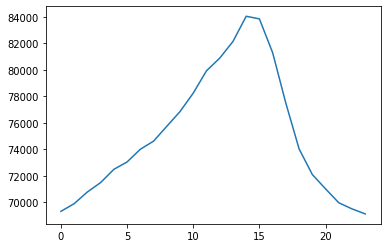

In [21]:
hourly_weather(weather_df, 'Snow').plot()

The plot for rain is almost the opposite of that for snow. 

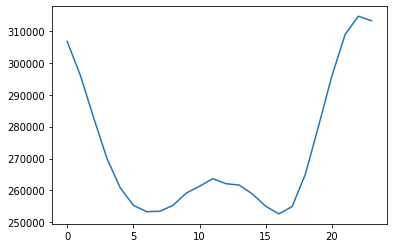

In [23]:
hourly_weather(weather_df, 'Rain').plot()

The fog plot is similar to snow. So some more invesitgation is called for.

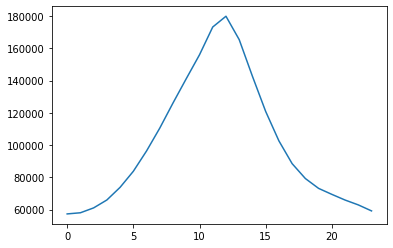

In [24]:
hourly_weather(weather_df, 'Fog').plot()

This is where we see the limitation of Python. Running hourly_weather fully utilizes one of my cores, while the rest are idle. 

In [25]:
%timeit hourly_weather(weather_df, 'Snow')

8min 2s ± 37.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Question 5
How many events of each severity did San Diego have? Produce a table and bar plot.

Just need to filter rows with City as San Diego and use the column_group_count function from question 1. No surprise as 45% of the events are light. I find the percent results easier to judge.

In [26]:
def san_diego_events(a_weather_df):
    return a_weather_df[a_weather_df['City'] == 'San Diego']

In [27]:
san_diego = san_diego_events(weather_df)

severity = column_group_count(san_diego, 'Severity')
severity.sort_values(ascending = False)

Severity
Light       2870
Moderate    1992
Severe      1365
Heavy         62
UNK           15
Other          3
dtype: int64

In [28]:
severity_percent = column_group_percent(san_diego, 'Severity')
severity_percent.sort_values(ascending = False)

Severity
Light       45.504994
Moderate    31.583954
Severe      21.642619
Heavy        0.983035
UNK          0.237831
Other        0.047566
dtype: float64

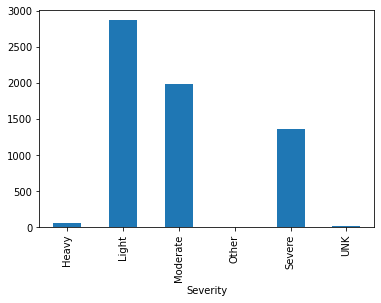

In [29]:
severity.plot.bar()